In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime
import seaborn as sns

In [7]:
import dwave
from dwave.cloud import Client
client = Client.from_config(config_file= '/home/rajarsi/.config/dwave/dwave.conf' )
dwave.cloud.config.load_config(['/home/rajarsi/.config/dwave/dwave.conf'])
import dimod
import neal
from dwave.system import LeapHybridCQMSampler, DWaveSampler , LeapHybridSampler
from dimod import ExactCQMSolver
from dimod import BinaryQuadraticModel as BQM
from dimod import QuadraticModel as QM
from dimod import ConstrainedQuadraticModel as CQM


#### Scratch 

In [ ]:
## define bqm ~
bqm = BQM({'x':2, 'y':-1,'z':1},{ ('x','y'):-1, ('x','z'): -2, ('y','z'): 1}, 0 , 'SPIN')
bqm


In [ ]:
## convert to CQM and add constraints ~
cqm = CQM.from_bqm(bqm)
cqm.add_constraint_from_iterable([('x','z',2), ('x',1), ('y', -1), ('y','z', 1) ], '<=', rhs= 3 , label= 'c1')
cqm.constraints['c1'].to_polystring()
# cqm.objective

In [ ]:
## setup sampler 
sampler = LeapHybridSampler()
# smpl_set = sampler.sample(bqm)

In [ ]:
# print(smpl_set)

### Example: Portfolio Optmisation

##### Getting Stock Data

In [75]:
def get_stock_data(stocks, start= datetime.datetime(2000,1,1) , end= datetime.datetime(2022,1,1) ) :
    """ Return stock data and covariace matrix corresponding to it """
    data = pd.DataFrame()
    for stock in stocks:
         data[stock] = pdr.DataReader(stock,data_source='yahoo', start= start, end= end)['Adj Close']

    rtrn_data = data/data.shift(1)
    rtrn_data =  np.log(rtrn_data[1:])
    cov_matrix = rtrn_data.cov()
    return rtrn_data, cov_matrix

<AxesSubplot:>

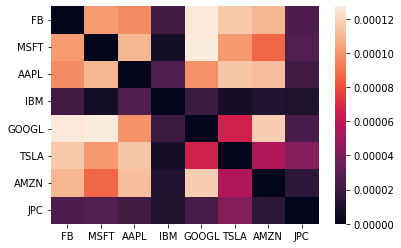

In [76]:
stocks= ['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']
data = get_stock_data(stocks)

cov_matrix = data[1]
mean_rtrn = data[0].mean()
for stock in stocks : cov_matrix[stock][stock] = 0
sns.heatmap(cov_matrix)

##### Setting up BQM

In [77]:
bqm = BQM('BINARY')
for stock in stocks : bqm.add_variable(stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: bqm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: bqm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        
# bqm

##### Simulated Annealing solver

In [78]:
sampler = neal.SimulatedAnnealingSampler()
# sampler.properties, sampler.parameters
pf_op = sampler.sample(bqm, num_sweeps= 100, num_sweeps_per_beta= 50, num_reads= 10 ,beta_schedule= 'geometric' ,seed= 1234)
## most optimal solution 
pf_op.first


Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.006958429141375026, num_occurrences=1)

##### Setting up QM

In [79]:
dimod.REAL_INTERACTIONS = True
qm = QM()
for stock in stocks : qm.add_variable('BINARY',stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: qm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: qm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        


##### Setting up CQM from QM

In [91]:
cqm = CQM.from_qm(qm)
# cqm.objective
vars = cqm.variables
vars =  [dimod.Binary(var) for var in vars ]

cqm.add_constraint( sum(vars) <= len(vars) - 2, label= 'max stock constraint')

rtrns = []
for stock in range(len(vars)) :
    rtrns.append(mean_rtrn[stock]*vars[stock])
rtrn = sum(rtrns)
cqm.add_constraint( rtrn  >= 0, label= 'min return constraint' )

'min return constraint'

##### Using ExactSolver 

In [92]:
pf_sample_set = ExactCQMSolver().sample_cqm(cqm)

In [97]:
pf_sample_set.first

Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.006958429141375027, num_occurrences=1, is_satisfied=array([ True,  True]), is_feasible=True)

##### Using 'INTEGER' variable type 

In [110]:
qm_int = QM()
for stock in stocks : qm_int.add_variable('INTEGER',stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: qm_int.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: qm_int.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })

cqm_int = CQM.from_qm(qm_int)
# cqm_int.objective
vars = cqm_int.variables
vars =  [dimod.Integer(var) for var in vars ]

## add constraints
cqm_int.add_constraint( sum(vars) <= 50 , label= 'max stock constraint')

rtrns = []
for stock in range(len(vars)) :
    rtrns.append(mean_rtrn[stock]*vars[stock])
rtrn = sum(rtrns)
cqm_int.add_constraint( rtrn  >= 1.5 , label= 'min return constraint' )        


'min return constraint'

In [111]:
pf_sample_set_int = LeapHybridCQMSampler().sample_cqm(cqm_int)

In [112]:
pf_sample_set_int

SampleSet(rec.array([([  0.,   0.,   0.,   0.,   0.,   0.,   0., 428.], -1.50312234, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   0., 428.], -1.50312234, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   1., 427.], -1.41536233, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   0., 428.], -1.50312234, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   0., 428.], -1.50312234, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   1.,   0.,   0.,   0., 427.], -1.44468821, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   1., 427.], -1.41536233, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   1.,   0.,   0.,   0., 427.], -1.44468821, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   1.,   0.,   0.,   0., 427.], -1.44468821, 1, False, [ True, False]),
           ([  0.,   0.,   0.,   0.,   0.,   0.,   1., 427.], -1.4153623

##### Using Leap's sampler

In [ ]:
sampler_cqm = LeapHybridCQMSampler()
# sample_set_leap = sampler_cqm.sample_cqm(cqm)

In [ ]:
# sample_set_leap.first

##### Using 'REAL' vartype in CQM

REAL type variables do not support interaactions, only linear terms should be used in objective and constraints

### Example: Independet Set Problem

MIS problem with hard constraints

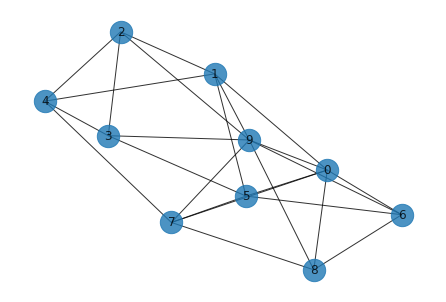

In [53]:
## initiate random graph~
import networkx as nx
from networkx import erdos_renyi_graph

nodes = 10
p = 0.5

rnd_graph = erdos_renyi_graph(nodes, p, seed= 1904892)
nx.draw(rnd_graph, with_labels= True, alpha= 0.8, node_size= 500)

In [54]:
## create quadratic model form graph
graph_qm = QM()
for node in rnd_graph.nodes : graph_qm.add_variable('BINARY', str(node) )
for var in graph_qm.variables : graph_qm.add_linear_from({var: -1})

graph_cqm = CQM.from_qm(graph_qm)
graph_vars = [dimod.Binary(var) for var in graph_cqm.variables]

edge_sum = []
for edge in list(rnd_graph.edges):
    edge_sum.append(graph_vars[edge[0]]*graph_vars[edge[1]])
edge_sum = sum(edge_sum)

graph_cqm.add_constraint(edge_sum == 0, label= 'edge sum constraint')


'edge sum constraint'

In [55]:
graph_sample_set = ExactCQMSolver().sample_cqm(graph_cqm)
df = graph_sample_set.to_pandas_dataframe()
df.sort_values(by=['energy'])
df = df.loc[df['is_satisfied']== True]
config = {}
for node in graph_cqm.variables :
     config[int(node)] = df.iloc[[-1]][node].to_numpy()[0]
nx.set_node_attributes(rnd_graph, name= 'color', values = config)

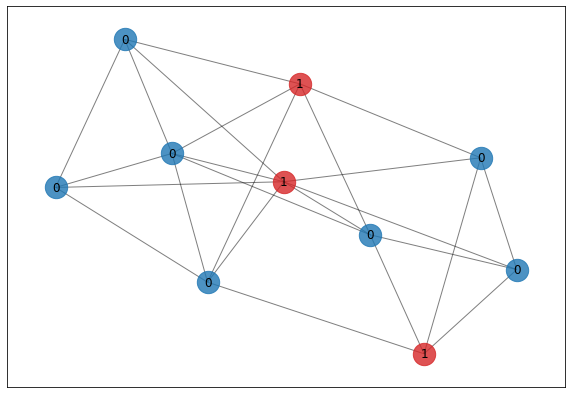

In [56]:
red = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 1  ]
blue = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 0  ]

plt.figure(figsize= (10,7))
pos = nx.spring_layout(rnd_graph)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= red, node_color= "tab:red",  alpha= 0.8, node_size= 500)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= blue, node_color= "tab:blue", alpha= 0.8, node_size= 500)
nx.draw_networkx_edges(rnd_graph,pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(rnd_graph, pos, config)
plt.show()

In [57]:
graph_sample_set = LeapHybridCQMSampler().sample_cqm(graph_cqm)
df = graph_sample_set.to_pandas_dataframe()
df.sort_values(by=['energy'])
df = df.loc[df['is_satisfied']== True]
config = {}
for node in graph_cqm.variables :
     config[int(node)] = df.iloc[[-1]][node].to_numpy()[0]
nx.set_node_attributes(rnd_graph, name= 'color', values = config)


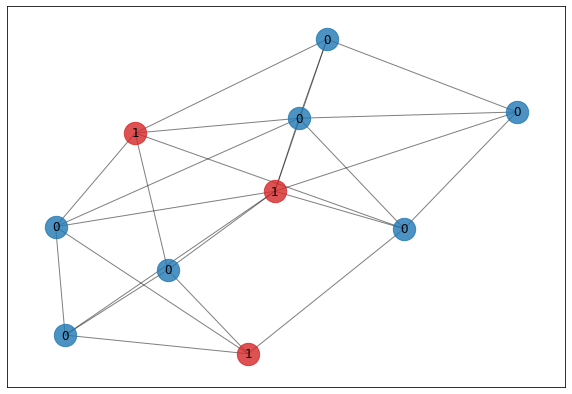

In [59]:
red = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 1  ]
blue = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 0  ]

plt.figure(figsize= (10,7))
pos = nx.spring_layout(rnd_graph)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= red, node_color= "tab:red",  alpha= 0.8, node_size= 500)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= blue, node_color= "tab:blue", alpha= 0.8, node_size= 500)
nx.draw_networkx_edges(rnd_graph,pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(rnd_graph, pos, config)
plt.show()

### Example: Graph Coloring

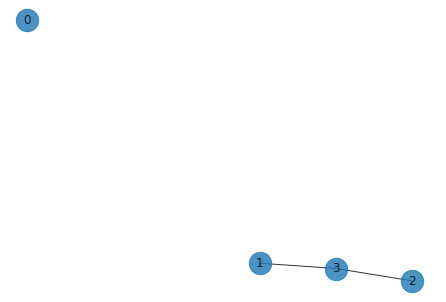

In [64]:
from dwave_networkx.algorithms import min_vertex_color_qubo

nodes = 4
p = 0.35

rnd_graph_mc = erdos_renyi_graph(nodes, p, seed= 1904892)
nx.draw(rnd_graph_mc, with_labels= True, alpha= 0.8, node_size= 500)

In [65]:
qm = min_vertex_color_qubo(rnd_graph_mc)

In [66]:
qm

{((0, 0), (0, 0)): -1,
 ((0, 1), (0, 1)): -1,
 ((0, 0), (0, 1)): 2,
 ((1, 0), (1, 0)): -1,
 ((1, 1), (1, 1)): -1,
 ((1, 0), (1, 1)): 2,
 ((2, 0), (2, 0)): -1,
 ((2, 1), (2, 1)): -1,
 ((2, 0), (2, 1)): 2,
 ((3, 0), (3, 0)): -1,
 ((3, 1), (3, 1)): -1,
 ((3, 0), (3, 1)): 2,
 ((1, 0), (3, 0)): 1,
 ((1, 1), (3, 1)): 1,
 ((2, 0), (3, 0)): 1,
 ((2, 1), (3, 1)): 1}

### Scratch Cell

In [73]:
graph_sample_set.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,energy,is_feasible,is_satisfied,num_occurrences
0,0,0,0,0,0,0,0,0,0,0,0.0,True,True,1
1,0,1,0,0,0,0,0,0,0,0,-1.0,True,True,1
2,1,0,0,0,0,0,0,0,0,0,-1.0,True,True,1
3,1,1,0,0,0,0,0,0,0,0,-2.0,False,False,1
4,0,0,1,0,0,0,0,0,0,0,-1.0,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1,1,0,1,1,1,1,1,1,1,-9.0,False,False,1
1020,0,0,1,1,1,1,1,1,1,1,-8.0,False,False,1
1021,0,1,1,1,1,1,1,1,1,1,-9.0,False,False,1
1022,1,0,1,1,1,1,1,1,1,1,-9.0,False,False,1
